In [1]:
import numpy as np
import pandas as pd
import gensim
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
import re

nltk.download('stopwords')
# !pip install -U gensim
# !pip install pyLDAvis
stopwords = stopwords.words('english')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sketcha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Loading the datasets

nyt_df = pd.read_csv('/Users/sketcha/lda/nyt.csv', sep=',')
print('Original Number of Columns: {}, rows: {}'.format(nyt_df.shape[1], nyt_df.shape[0]) )

columns = ['pub_date', 'web_url','content']
nyt_df = nyt_df[columns]
nyt_df.drop_duplicates(subset ="content", inplace = True)

print(nyt_df.shape)
nyt_df.dropna(inplace=True)

nyt_df.head()

Original Number of Columns: 23, rows: 19927
(19743, 3)
After droping duplicate rows and unneccesary columns
 Number of Columns: 3        , rows: 19742


,pub_date,web_url,content
0,2020-03-01T20:00:06+0000,https://www.nytimes.com/2020/03/01/opinion/cor...,Advertisement Supported by We need to be on gu...
1,2020-03-01T16:58:17+0000,https://www.nytimes.com/2020/03/01/upshot/coro...,Advertisement Supported by A sick day? Remote ...
2,2020-03-01T18:10:26+0000,https://www.nytimes.com/2020/03/01/health/coro...,Advertisement Supported by Two cases detected ...
3,2020-03-01T04:04:45+0000,https://www.nytimes.com/2020/02/29/us/trump-co...,Advertisement Supported by President Trump fou...
4,2020-03-01T12:00:08+0000,https://www.nytimes.com/2020/03/01/business/th...,Advertisement Supported by with interest By Da...


**Pre-processing**

In [4]:
# Pre-processing steps

%timeit
# initalizing the werdnet lemmatizer
lm = WordNetLemmatizer()
# creating a new column to store rows after processing
nyt_df['post_processed'] = ''

stopwords.extend(['advertisement', 'supported'])
# stopwords.extend(['rt'])
def processing(content):

    content = content.split(' ')
#     removing stopwords
    content = [word.strip().lower() for word in content if word.lower() not in stopwords]
#     removing punctuations
    rx = re.compile('([&#.:?!-()])*')
    content = [rx.sub('', word) for word in content]
    
    content = [word for word in content if len(word)>1 and word.isalpha()]
#   lemmatizing  
    content = [lm.lemmatize(word) for word in content]

    return ' '.join(content)

# removing opinion articles
for i in range(len(nyt_df)):
    if 'opinion' not in nyt_df.iloc[i,1]:
        nyt_df.iloc[i,-1] = processing(nyt_df.iloc[i,2])
        

nyt_df.dropna(inplace=True)
nyt_df.head()

After Removing Opinion articles, rows are reduced to :  19742


,pub_date,web_url,content,post_processed
0,2020-03-01T20:00:06+0000,https://www.nytimes.com/2020/03/01/opinion/cor...,Advertisement Supported by We need to be on gu...,
1,2020-03-01T16:58:17+0000,https://www.nytimes.com/2020/03/01/upshot/coro...,Advertisement Supported by A sick day? Remote ...,sick day remote work easy job day care center ...
2,2020-03-01T18:10:26+0000,https://www.nytimes.com/2020/03/01/health/coro...,Advertisement Supported by Two cases detected ...,two case detected week apart washington state ...
3,2020-03-01T04:04:45+0000,https://www.nytimes.com/2020/02/29/us/trump-co...,Advertisement Supported by President Trump fou...,president trump found veering message discussi...
4,2020-03-01T12:00:08+0000,https://www.nytimes.com/2020/03/01/business/th...,Advertisement Supported by with interest By Da...,interest david going tax week said it maybe ac...


In [6]:
# Frequency filtering

import gensim.corpora as corpora
#decomposing sentences into tokens 
tokens = [sentence.split(' ') for sentence in nyt_df['post_processed'] ]

# Create Dictionary
dct = corpora.Dictionary(tokens)
print('Unique words before filtering', len(dct))
# no_below= 20
dct.filter_extremes(no_below= 20, no_above=0.25 )
print('Unique words after filtering', len(dct))
# Create Corpus
corpus = [dct.doc2bow(token) for token in tokens]

Unique words before filtering 97389
Unique words after filtering 18942


**Coherence**

In [54]:
# Obtaining coherence results

from gensim.models import CoherenceModel

scores = []
for k in range(1,26):
  lda_model = gensim.models.LdaModel(corpus=corpus, id2word=dct, num_topics=k, 
                                       random_state=100, chunksize=128, passes=10,
                                       per_word_topics=True)

  coherence_model_lda = CoherenceModel(model=lda_model, texts=tokens, dictionary=dct, coherence='c_v')
  coherence_lda = coherence_model_lda.get_coherence()
  print( 'coherence_lda', coherence_lda)

  scores.append(coherence_lda)

/Users/sketcha/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


coherence_lda 0.3905385827917625
coherence_lda 0.42011767992460114
coherence_lda 0.5312530167309598
coherence_lda 0.5262512555115642
coherence_lda 0.586540750732282
coherence_lda 0.5543499249735379
coherence_lda 0.5607998230814732
coherence_lda 0.5756459287595258
coherence_lda 0.5704903576353162
coherence_lda 0.5950065333781465
coherence_lda 0.5940690305940548
coherence_lda 0.5897205717445254
coherence_lda 0.60746961451111
coherence_lda 0.6112888276498991
coherence_lda 0.6055434125009568
coherence_lda 0.6087633703999652
coherence_lda 0.6104301692807593
coherence_lda 0.6127430568690928
coherence_lda 0.608020258524658
coherence_lda 0.602649221245884
coherence_lda 0.6205021924187988
coherence_lda 0.5988912579203806
coherence_lda 0.5998985509966611
coherence_lda 0.5979047172432472
coherence_lda 0.6017811352132345


/Users/sketcha/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


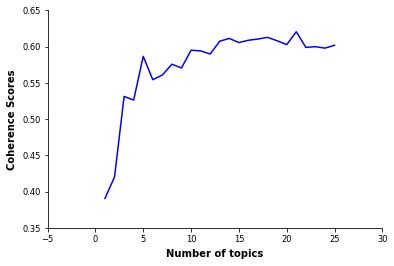

In [59]:
# Plotting coherence results

selected_topics = np.argmax(scores)+3
plt.plot(list(range(1,26)), scores, color= "blue")
plt.xlabel('Number of topics')
plt.ylabel('Coherence Scores')
plt.savefig('nyt_coherence')

<b> Final Model </b>

In [60]:
# constructing the lda model

selected_topics= 6
lda_model = gensim.models.LdaModel(corpus=corpus, id2word=dct, num_topics=selected_topics, 
                                           random_state=100, chunksize=128, passes=10 )

/Users/sketcha/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [52]:
#save lda model 
lda_model.save("nyt.model")

/Users/sketcha/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Visualization tool**

In [61]:
# !pip install pyLDAvis
import pyLDAvis.gensim_models
# import pickle 
import pyLDAvis

pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda_model, corpus, dct)

/Users/sketcha/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.143035 -0.037724       1        1  22.212330
0      0.219174 -0.137743       2        1  20.082213
1      0.042196  0.206988       3        1  18.635151
5     -0.035675  0.153787       4        1  16.088833
4     -0.126012 -0.108306       5        1  12.944796
2     -0.242717 -0.077002       6        1  10.036677, topic_info=          Term          Freq         Total Category  logprob  loglift
1930   vaccine  39035.000000  39035.000000  Default  30.0000  30.0000
243     county  19929.000000  19929.000000  Default  29.0000  29.0000
57          dr  17222.000000  17222.000000  Default  28.0000  28.0000
1108     biden  17700.000000  17700.000000  Default  27.0000  27.0000
1001      mask  14872.000000  14872.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
371     result   3132.049068   7136.993182   Topic6  -5.5053   1.4753
844      level   3001.970397   8275.699881   Topic6  -5.5477   1.2849
365   reported   3329.241190  14476.543475   Topic6  -5.4442   0.8291
5917     covid   3037.636936   9884.781834   Topic6  -5.5359   1.1190
716       rate   3070.492005  13415.868957   Topic6  -5.5251   0.8243

[434 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
0          4  0.999386          
443        3  0.999428   accused
777        2  0.995276     actor
777        3  0.004340     actor
573        1  0.823628  actually
...      ...       ...       ...
12180      1  0.998733   workout
2791       1  0.999472      yeah
15789      4  0.998054    yellen
2983       1  0.999290       yes
775        1  0.999739       you

[923 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 6, 5, 3])

**Plotting**

In [31]:
# Labeling the topics
topics_name = ['Sports', 'Community',  'U.S Politics', 'Economy', 'Travel Restrictions', 'Vaccination', 'Travel Restrictions']
predicted_topics = lda_model[corpus]

probs, topics = [], []
for k in predicted_topics:
  # print(k)
  k.sort(key=lambda x:x[1])
  topics.append(topics_name[ k[0][0] ] ), probs.append(k[0][1])

lda_model.show_topics()
nyt_df['Predicted Topic'] = topics
nyt_df['Probability'] = probs
dates = [row.split('T')[0] for row in nyt_df['pub_date'] ]
nyt_df['pub_date'] = dates

/Users/sketcha/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/sketcha/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


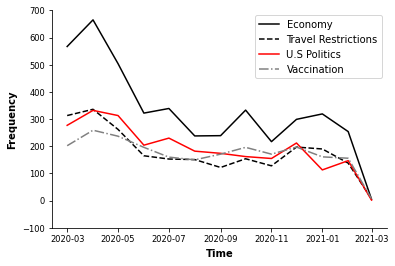

In [47]:
# Plotting for the topics discussed in the results section only

topic_name = ['Economy', 'Travel Restrictions', 'U.S Politics', 'Vaccination' ]

dates = [row.split('T')[0] for row in nyt_df['pub_date'] ]
nyt_df['pub_date'] = dates

nyt_df['new_date'] =  pd.to_datetime(nyt_df['pub_date'], format='%Y-%m-%d')
nyt_df = nyt_df.set_index('new_date', drop=True)


plt.figure()
for i in range(len(topic_name)):
    
    x = nyt_df[nyt_df['Predicted Topic'] == topic_name[i] ]
    curr = x.groupby(x.index.strftime('%Y-%m')).count()
    curr = curr.reset_index()
    curr['x_axis'] = pd.to_datetime(curr['new_date'], format='%Y-%m')

    plt.plot(curr.x_axis, curr['Predicted Topic'], label = topic_name[i])
    
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.xticks()
plt.yticks()
plt.savefig('nyt_alltopics_plot')
plt.show()

In [45]:
# Plotting for the topics "Vaccination" and "Travel Restrictions"

topic_name = ['Vaccination', 'Travel Restrictions']

dates = [row.split('T')[0] for row in nyt_df['pub_date'] ]
nyt_df['pub_date'] = dates

nyt_df['new_date'] =  pd.to_datetime(nyt_df['pub_date'], format='%Y-%m-%d')
nyt_df = nyt_df.set_index('new_date', drop=True)


plt.figure()
for i in range(len(topic_name)):
    
    x = nyt_df[nyt_df['Predicted Topic'] == topic_name[i] ]
    curr = x.groupby(x.index.strftime('%Y-%m')).count()
    curr = curr.reset_index()
    curr['x_axis'] = pd.to_datetime(curr['new_date'], format='%Y-%m')

    plt.plot(curr.x_axis, curr['Predicted Topic'], label = topic_name[i], color= "red")
    
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.xticks()
plt.yticks()
plt.savefig('nyt_vaccine_travel')
plt.show()

/Users/sketcha/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


SyntaxError: positional argument follows keyword argument (<ipython-input-45-0e06b1a431aa>, line 18)

/Users/sketcha/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


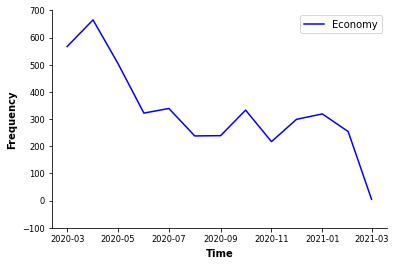

In [34]:
# Plotting for the topic "Economy"

topic_name = ['Economy']

dates = [row.split('T')[0] for row in nyt_df['pub_date'] ]
nyt_df['pub_date'] = dates

nyt_df['new_date'] =  pd.to_datetime(nyt_df['pub_date'], format='%Y-%m-%d')
nyt_df = nyt_df.set_index('new_date', drop=True)


plt.figure()
for i in range(len(topic_name)):
    
    x = nyt_df[nyt_df['Predicted Topic'] == topic_name[i] ]
    curr = x.groupby(x.index.strftime('%Y-%m')).count()
    curr = curr.reset_index()
    curr['x_axis'] = pd.to_datetime(curr['new_date'], format='%Y-%m')

    plt.plot(curr.x_axis, curr['Predicted Topic'], label = topic_name[i], color= 'blue')
    
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.xticks()
plt.yticks()
plt.savefig('nyt_economy_')
plt.show()

/Users/sketcha/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


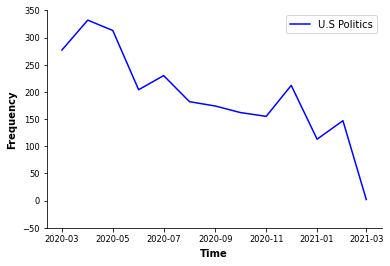

In [62]:
#Plotting for the topic "U.S Politics"

topic_name = ['U.S Politics']

dates = [row.split('T')[0] for row in nyt_df['pub_date'] ]
nyt_df['pub_date'] = dates

nyt_df['new_date'] =  pd.to_datetime(nyt_df['pub_date'], format='%Y-%m-%d')
nyt_df = nyt_df.set_index('new_date', drop=True)


plt.figure()
for i in range(len(topic_name)):
    
    x = nyt_df[nyt_df['Predicted Topic'] == topic_name[i] ]
    curr = x.groupby(x.index.strftime('%Y-%m')).count()
    curr = curr.reset_index()
    curr['x_axis'] = pd.to_datetime(curr['new_date'], format='%Y-%m')

    plt.plot(curr.x_axis, curr['Predicted Topic'], label = topic_name[i], color= 'blue')
    
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.xticks()
plt.yticks()
plt.savefig('us_politics_plot')
plt.show()

In [12]:
#saving as .csv

import pandas as pd
nyt_df.reset_index(drop=True, inplace=True)
nyt_df.to_csv('nyt_topics.csv', index=True, columns=['pub_date', 'content', 'Predicted Topic'], sep=',')

In [15]:
# viewig top documents for a given topic

#topic_name = ['']

x = nyt_df[ nyt_df['Predicted Topic'] == topics_name[0] ]
x = x.sort_values('Probability', ascending=False)

x = x[['content', 'keywords']]
x.head(7)

,content,keywords
15194,"Advertisement transcript Hello? Hi. Hi, how ar...","[{'name': 'subject', 'value': 'Love (Emotion)'..."
8233,"Advertisement transcript Hi, Savannah. Good mo...","[{'name': 'subject', 'value': 'Coronavirus (20..."
5507,Advertisement Supported by Five housebound pho...,"[{'name': 'subject', 'value': 'Photography', '..."
8553,The rapper and actor has a real name: Colson B...,"[{'name': 'subject', 'value': 'Rap and Hip-Hop..."
9174,Advertisement Supported by Frank Miller and To...,"[{'name': 'creative_works', 'value': 'Cursed (..."
13562,Advertisement Supported by Teens competing for...,"[{'name': 'subject', 'value': 'Music', 'rank':..."
16296,Advertisement Supported by Vows LaMarr Coles p...,"[{'name': 'subject', 'value': 'Weddings and En..."
